In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import timm 
import torch
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.callback.fp16 import *

#import pydicom
#!pip install -qU python-gdcm pydicom pylibjpeg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 5.2 MB/s eta 0:00:00a 0:00:01


In [3]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [4]:
df['filepath'] = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10011/220375232.png


In [5]:
df.iloc[0,-1]

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png'

In [6]:
df.density.value_counts()

B    12651
C    12175
A     3105
D     1539
Name: density, dtype: int64

In [7]:
df=df[df['density'] == 'B']
df.shape

(12651, 15)

In [8]:
df = df[['filepath', 'cancer']]
df.head()

,filepath,cancer
53,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10102/618254763.png,0
54,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10102/1245250349.png,0
55,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10102/1304802631.png,0
56,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10102/1480506800.png,0
57,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10102/453020471.png,0


In [9]:
df.cancer.value_counts()

0    12342
1      309
Name: cancer, dtype: int64

# Train Test Split

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, stratified by the "target" column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cancer'], random_state=1)
print('shape of train_df', train_df.shape)
print('shape of test_df', test_df.shape)

shape of train_df (10120, 2)
shape of test_df (2531, 2)


# Sampling

In [11]:
# Class count
count_class_0, count_class_1 = train_df.cancer.value_counts()

# Divide by class
df_class_0 = train_df[train_df['cancer'] == 0]
df_class_1 = train_df[train_df['cancer'] == 1]

In [12]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1, random_state=1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

df_train_under = df_train_under.sample(frac=1, random_state=1)

print('Random under-sampling:')
print(df_train_under.cancer.value_counts())

Random under-sampling:
1    247
0    247
Name: cancer, dtype: int64


In [13]:
df_train_under.shape

(494, 2)

In [14]:
df_train_under.dtypes

filepath    object
cancer       int64
dtype: object

In [15]:
df_train_under.head()

,filepath,cancer
9355,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/20009/936994890.png,1
6550,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/17111/543347978.png,0
28850,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/40819/1071480339.png,0
43102,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/56478/22682741.png,0
29638,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/41610/1957729736.png,1


# Training

In [16]:
db = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                   get_x=lambda x:x[0],
                   get_y=lambda x:x[1],
                   splitter  = RandomSplitter(seed=1))

dls = db.dataloaders(df_train_under.values, num_workers=0, bs=32)

In [17]:
# x,y = dls.one_batch()
# mean=x.mean(dim=[0,2,3])
# std=x.std(dim=[0,2,3])
# batch_tfms = [IntToFloatTensor(), Normalize.from_stats(mean,std)]
# mean,std

In [18]:
#batch_tfms = [IntToFloatTensor(), Normalize.from_stats(mean,std)]

In [19]:
# x,y = dls.one_batch()
# x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

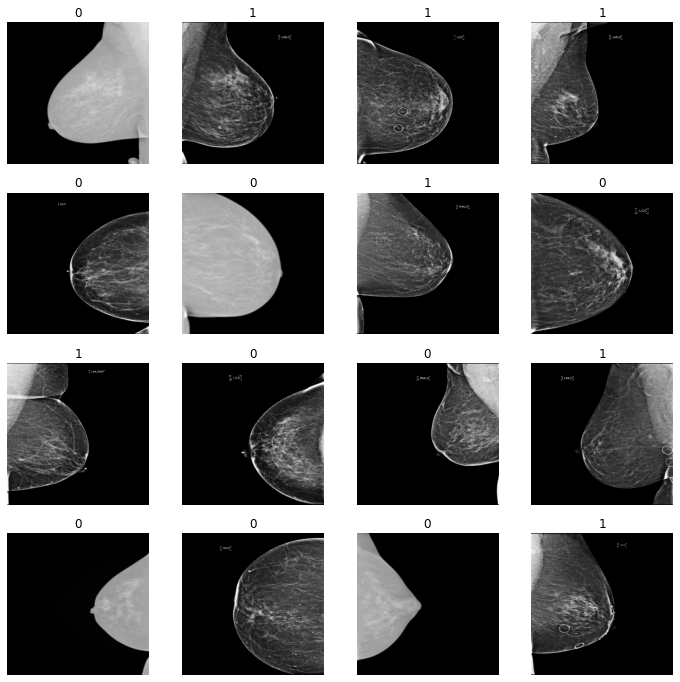

In [20]:
dls.show_batch(max_n=16)

In [21]:
all_densenet_models = timm.list_models('*efficientnetv2_s*')
all_densenet_models

['efficientnetv2_s',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_s_in21ft1k',
 'tf_efficientnetv2_s_in21k']

In [22]:
learn = vision_learner(dls, 'efficientnetv2_s', metrics=error_rate).to_fp16()

SuggestedLRs(valley=0.007585775572806597)

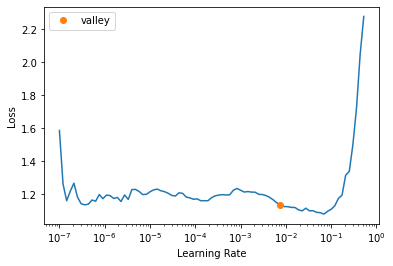

In [23]:
learn.lr_find()

In [25]:
#0.002
#1.5e-7
#1e-8
#
learn.fit_one_cycle(10, 0.007)

epoch,train_loss,valid_loss,error_rate,time
0,1.154125,2.841073,0.489796,00:12
1,1.000744,0.859854,0.479592,00:12
2,0.952038,0.613692,0.316327,00:12
3,0.898316,0.621588,0.367347,00:12
4,0.835368,0.767205,0.357143,00:12
5,0.762946,0.744223,0.387755,00:12
6,0.685655,0.619313,0.316327,00:12
7,0.631552,0.688403,0.346939,00:12
8,0.577125,0.633414,0.316327,00:12
9,0.550077,0.643434,0.336735,00:12


SuggestedLRs(valley=0.005248074419796467)

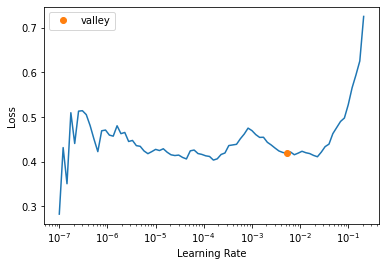

In [26]:
learn.lr_find()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=2e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.384122,0.639863,0.326531,00:15
1,0.399891,0.642155,0.326531,00:15
2,0.382279,0.621204,0.295918,00:15
3,0.387643,0.639050,0.316327,00:15
4,0.364901,0.634661,0.346939,00:15
5,0.372308,0.624414,0.326531,00:15
6,0.343412,0.606412,0.316327,00:15
7,0.368613,0.608661,0.295918,00:15
8,0.360589,0.610406,0.295918,00:15
9,0.369340,0.607108,0.316327,00:15


In [ ]:
#learn.fine_tune(6, freeze_epochs=3, base_lr=8e-5)
#learn.fine_tune(6, base_lr=8e-5)

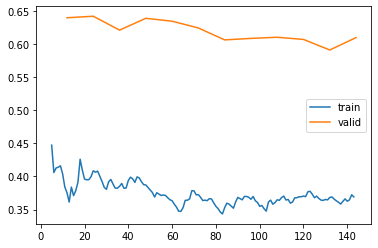

In [28]:
learn.recorder.plot_loss()

In [29]:
learn.save('us_512_B_enet_ft', with_opt=False)

Path('models/us_512_B_enet_ft.pth')

In [34]:
#learn.export()

# Validation Data Metric

In [36]:
# # # interp = ClassificationInterpretation.from_learner(learn)
# # # losses,idxs = interp.top_losses()
# # # len(dls.valid_ds)==len(losses)==len(idxs)
# # # interp.plot_confusion_matrix(figsize=(7,7))

# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

In [37]:
# interp.plot_top_losses(5, nrows=1)

# Test Data Metric

In [38]:
# Class count
count_class_0_test, count_class_1_test = test_df.cancer.value_counts()

# Divide by class
df_class_0_test = test_df[test_df['cancer'] == 0]
df_class_1_test = test_df[test_df['cancer'] == 1]

In [39]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under_test = df_class_0_test.sample(count_class_1_test, random_state=1)
df_test_under = pd.concat([df_class_0_under_test, df_class_1_test], axis=0)

print('Random under-sampling:')
print(df_test_under.cancer.value_counts())

Random under-sampling:
0    62
1    62
Name: cancer, dtype: int64


In [42]:
temp = learn.predict('/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_512/train_images_processed_cv2_dicomsdl_512/10006/1459541791.png')
temp[0]

'0'

In [43]:
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(int(predictions[idx]), 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [44]:
df_test_under.shape

(124, 2)

In [45]:
from tqdm import tqdm
from IPython.display import clear_output

labels = []
preds = []

#preds = learn.predict(test_df['filepath'])
#labels = test_df['cancer']

for _, row in tqdm(df_test_under.iterrows()):
    pred = int(learn.predict(row.filepath)[0])
    preds.append(learn.predict(row.filepath)[0])#pred)
    label = row.cancer
    labels.append(label)
    clear_output(wait=True)

124it [00:32,  3.85it/s]


In [46]:
type(label)

int

In [47]:
score = pfbeta(labels=labels, predictions=preds, beta=1)
print(score)

0.5891472868217054


In [ ]:
#np.save('/kaggle/working/', preds)

In [ ]:
#np.save('/kaggle/working/', labels)